# Experiment Data Exploration and Analysis

## Simulate Data
Modified from a coworker's (Rob Wang) code

In [1]:
import numpy as np
import pandas as pd

np.random.seed(1234) # so same results throughout below
n = 20000

# Generate two lists of different conversion rates
p1 = 1/20
p2 = 1/25
group1_conv = list(np.random.binomial(1, p1, n))
group2_conv = list(np.random.binomial(1, p2, n))

# Generate country values randomly
countries = ["US","CA","MX"]
probs = [0.6,0.25,0.15]
country_list = list(np.random.choice(countries, size = 2*n,p=probs))

# Generate random dates
started = '2024-08-01'
ended = '2024-08-31'
date_range = pd.date_range(start=started, end=ended)
randomized_dates = np.random.choice(date_range, size=2*n)
bucket_dates = [pd.Timestamp(date).strftime('%Y-%m-%d') for date in randomized_dates]
#set(bucket_dates)

# Generate dataframe
data = {
    'bucket': ['control'] * len(group1_conv) + ['treatment'] * len(group2_conv),
    'converted': group1_conv + group2_conv,
    'country': country_list,
    'bucket_date': bucket_dates
}
data = pd.DataFrame(data)
data = data.sample(frac=1)
## Rename index pre-shuffle as unique token
data = data.reset_index().rename(columns={'index': 'token'})

# Generate revenue column
mean = 100
std_dev = 50
data['revenue'] = np.where(data['converted'] == 1,np.random.normal(loc=mean, scale=std_dev, size=len(data)),0)
# round to 2 digts all at once (instead of using a loop to round)
data['revenue'] = np.trunc(data['revenue'] * 100) / 100

# Randomly triple a subset of the data's revenue 
num_rows = 5000
row_indices = data.sample(n=num_rows).index
data.loc[row_indices, 'revenue'] *= 3

# Randomly increase treatment group revenue by 500
num_rows = 400
treatment_df = data[(data['bucket'] == 'treatment') & (data['converted'] == 1)]
row_indices = treatment_df.sample(n=num_rows).index
data.loc[row_indices, 'revenue'] += 500

# Randomly remove some rows
num_rows = 500
drop_rows = data.sample(n=num_rows).index
data = data.drop(drop_rows)

In [2]:
## Simulated experiment data
print(data.shape)
data.head()

(39500, 6)


,token,bucket,converted,country,bucket_date,revenue
0,35825,treatment,1,CA,2024-08-11,571.17
1,36596,treatment,0,CA,2024-08-13,0.00
2,37942,treatment,0,US,2024-08-02,0.00
3,12854,control,0,MX,2024-08-10,0.00
4,26703,treatment,0,MX,2024-08-06,0.00


## Validation, Cleanup and Experiment Overview

In [3]:
## shows size, columns, counts (nulls), object types

## changing 'token' to a string (from an int) so it doesn't keep showing up for mean,sum, etc
data.token = data.token.astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39500 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   token        39500 non-null  object 
 1   bucket       39500 non-null  object 
 2   converted    39500 non-null  int64  
 3   country      39500 non-null  object 
 4   bucket_date  39500 non-null  object 
 5   revenue      39500 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 2.1+ MB


array([[<AxesSubplot:title={'center':'converted'}>,
        <AxesSubplot:title={'center':'revenue'}>]], dtype=object)

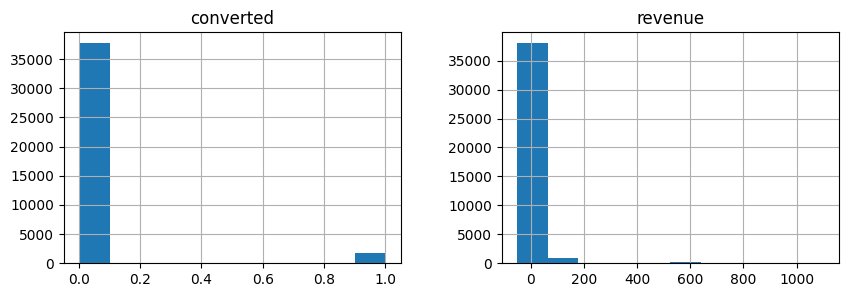

In [4]:
data.hist(figsize =(10,3))

In [5]:
## Looking at mean/median, std, min, max mostly for numeric
# We have some negative revenue (exclude? Yeah, will below)
data.describe()

,converted,revenue
count,39500.000000,39500.000000
mean,0.045570,10.718056
std,0.208552,69.578088
min,0.000000,-51.040000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1100.150000


In [6]:
# len(data[data.revenue < 0]) # 34 instances of 20K, we can remove negatives
df = data[data.revenue >= 0]
df.describe()

,converted,revenue
count,39466.000000,39466.000000
mean,0.044747,10.741794
std,0.206751,69.602383
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1100.150000


In [7]:
## Experiment overview: counts, conversion rate, avg revenue

# unique counts by bucket + just a quick check on uniques for others (ignore unique revenue...)
print(df.groupby('bucket').nunique())

## revenue looks higher, converted looks lower
df.groupby('bucket').mean()

           token  converted  country  bucket_date  revenue
bucket                                                    
control    19720          2        3           31      951
treatment  19746          2        3           31      790


,converted,revenue
bucket,,
control,0.049189,6.162150
treatment,0.040312,15.315409


bucket_date  bucket   
2024-08-01   control      658
             treatment    628
2024-08-02   control      648
             treatment    619
2024-08-03   control      643
Name: token, dtype: int64


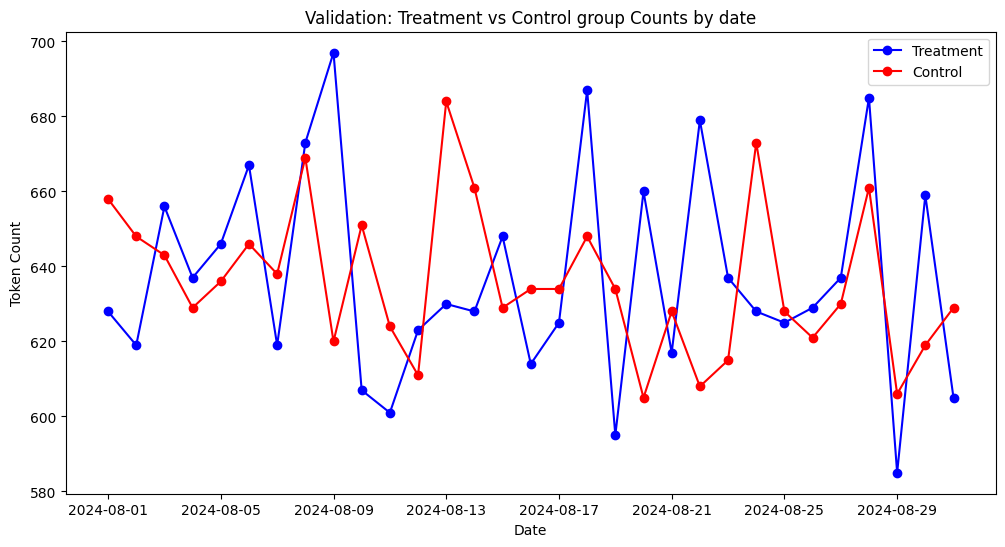

In [8]:
# confirm experiment is random/data is valid
exp = df.groupby(['bucket_date','bucket'])['token'].count()
print(exp.head())

## plot
## data for show vs control
t = df[df.bucket == 'treatment'].groupby(['bucket_date'])['token'].count()
c = df[df.bucket == 'control'].groupby(['bucket_date'])['token'].count()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Token Count')
plt.title('Validation: Treatment vs Control group Counts by date')

# Format x-axis to prevent labels from being cluttered
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))  # Control the number of x-ticks

## add series
plt.plot(t.index, t.values, label='Treatment', color='blue', linestyle='-', marker='o')
plt.plot(c.index, c.values, label='Control', color='red', linestyle='-', marker='o')

# include legend
plt.legend(loc='best')

# ## Quickest/ugliest way: import the matplotlib package and then uses these 3 lines:
# plt.plot(t)
# plt.plot(c)
plt.show()

# -> looks pretty random between groups!

In [9]:
exp_counts = df.groupby(['country','bucket'])['token'].nunique()
#print(exp_counts)

exp_conv = df.groupby(['country','bucket'])['converted','revenue'].sum()
#print(exp_conv)

## combine + add conversion rate + 
joined_df = pd.merge(exp_counts, exp_conv, on=['country', 'bucket'])
## conversion rate
joined_df['conversion'] = joined_df['converted'] / joined_df['token']
## revenue / converted
joined_df['avg_rev_conv'] = joined_df['revenue'] / joined_df['converted']
## revenue / total
joined_df['avg_rev_all'] = joined_df['revenue'] / joined_df['token']
overview_df = joined_df.reset_index()

## just in case, show all columns
pd.set_option('display.max_rows', None)
print(overview_df)

## Conversion is lower in all 3 countries,  avg revenue is higher in all 3

  country     bucket  token  converted    revenue  conversion  avg_rev_conv  \
0      CA    control   4962        239   30495.67    0.048166    127.596946   
1      CA  treatment   4929        194   73122.36    0.039359    376.919381   
2      MX    control   3056        151   20127.59    0.049411    133.295298   
3      MX  treatment   2880        121   41414.63    0.042014    342.269669   
4      US    control  11702        580   70894.33    0.049564    122.231603   
5      US  treatment  11937        481  187881.07    0.040295    390.605135   

   avg_rev_all  
0     6.145842  
1    14.835131  
2     6.586253  
3    14.380080  
4     6.058309  
5    15.739388  


/tmp/ipykernel_3560/1573685600.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  exp_conv = df.groupby(['country','bucket'])['converted','revenue'].sum()


In [10]:
## Another way to get this summary table using SQL
## there are a few different ways to do this (SQL in python)
## Colab example:
# %pip install pandasql
# from pandasql import sqldf
import sqlite3
conn = sqlite3.connect(':memory:')
df.to_sql('data', conn, index=False, if_exists='replace')

query = """
SELECT
    country
  , bucket
  , COUNT(*) AS sample_size
  , SUM(converted) AS converted
  , SUM(revenue) AS revenue
  , CAST(SUM(converted) AS FLOAT)/count(*) AS conversion -- cast to not round conversion to 0 decimals
  , AVG(revenue) AS avg_rev_all
  , AVG(revenue * converted) AS avg_rev_con
FROM data
GROUP BY 1,2
ORDER BY 1,2
"""

result_df = pd.read_sql_query(query, conn)
conn.close()
print(result_df)

  country     bucket  sample_size  converted    revenue  conversion  \
0      CA    control         4962        239   30495.67    0.048166   
1      CA  treatment         4929        194   73122.36    0.039359   
2      MX    control         3056        151   20127.59    0.049411   
3      MX  treatment         2880        121   41414.63    0.042014   
4      US    control        11702        580   70894.33    0.049564   
5      US  treatment        11937        481  187881.07    0.040295   

   avg_rev_all  avg_rev_con  
0     6.145842     6.145842  
1    14.835131    14.835131  
2     6.586253     6.586253  
3    14.380080    14.380080  
4     6.058309     6.058309  
5    15.739388    15.739388  


bucket    control  treatment
country                     
CA       0.048166   0.039359
MX       0.049411   0.042014
US       0.049564   0.040295


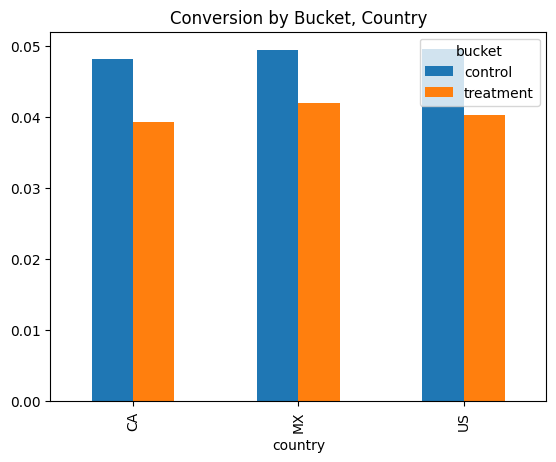

In [11]:
## Conversion
pivot_df = overview_df.pivot(index='country', columns='bucket', values='conversion')
print(pivot_df)
pivot_df.plot(kind = 'bar')
plt.title('Conversion by Bucket, Country')
plt.show()

bucket      control   treatment
country                        
CA       127.596946  376.919381
MX       133.295298  342.269669
US       122.231603  390.605135


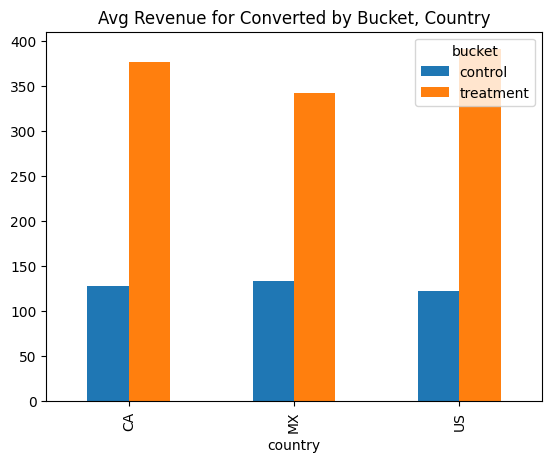

In [12]:
## avg_revenue
pivot_df = overview_df.pivot(index='country', columns='bucket', values='avg_rev_conv')
print(pivot_df)
pivot_df.plot(kind = 'bar')
plt.title('Avg Revenue for Converted by Bucket, Country')
plt.show()

bucket    control  treatment
country                     
CA       6.145842  14.835131
MX       6.586253  14.380080
US       6.058309  15.739388


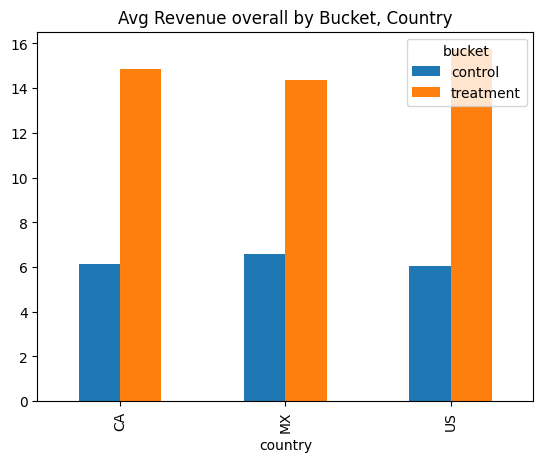

In [13]:
## avg_revenue_overall
pivot_df = overview_df.pivot(index='country', columns='bucket', values='avg_rev_all')
print(pivot_df)
pivot_df.plot(kind = 'bar')
plt.title('Avg Revenue overall by Bucket, Country')
plt.show()

## Experiment Statistics

In [14]:
## So we have the overview/directional results
# Now let's check statistical significence (p-values) and get some confidence intervals

## recap
print(df.groupby('bucket')['token'].nunique())
df.groupby('bucket').mean()

bucket
control      19720
treatment    19746
Name: token, dtype: int64


,converted,revenue
bucket,,
control,0.049189,6.162150
treatment,0.040312,15.315409


In [15]:
import scipy.stats as stats

### Chi-Square test
Good test for conversion here (i.e. for categorical data)

You just need summary stats to run like a formula (ie table of group A vs B and converted vs not)

In [16]:
## Chi-Square for Conversion
sum_table = pd.crosstab(df['bucket'], df['converted'])

# Get the counts for control and treatment
control_conv = sum_table.loc['control', 1]
control_total = sum_table.loc['control'].sum()
treatment_conv = sum_table.loc['treatment', 1]
treatment_total = sum_table.loc['treatment'].sum()

chi2_stat, p_value, dof, expected = stats.chi2_contingency(sum_table)
print('summary table')
print(sum_table)
print() ## just adding a space
print(f'control conv: {control_conv/control_total:.4f}')
print(f'treatment conv: {treatment_conv/treatment_total:.4f}')
#print('treatment conv: ' + str(round(treatment_conv/treatment_total,4))) # old way I would have done this
print(f'p-value: {p_value:.6f}')
print() ## just adding a space
print('Shh! (actual control conversion from simulated code): ' + str(1/20))
print('Shh! (actual treatment conversion from simulated code): ' + str(1/25))
#print(stats.chi2_contingency(sum_table))
 
# p-value is the odds of seeing this or more extreme of a result given there is no effect (null is no effect)
# very stat sig here.

summary table
converted      0    1
bucket               
control    18750  970
treatment  18950  796

control conv: 0.0492
treatment conv: 0.0403
p-value: 0.000022

Shh! (actual control conversion from simulated code): 0.05
Shh! (actual treatment conversion from simulated code): 0.04


### Z-test
Should ballpark match chi-square above (at least for 2 sample binomal here comparing means)

Need to calculate overall conversion to get binomial standard error, z-test stat

In [17]:
## Z-test for conversion
# The 4 count variables here are from chi-square code above
p1 = control_conv / control_total
p2 = treatment_conv / treatment_total
# overall conversion
p = (control_conv + treatment_conv) / (control_total + treatment_total)

se = np.sqrt(p * (1 - p) * (1 / control_total + 1 / treatment_total)) # Binomial Standard error
z = (p1 - p2) / se # Z-test statistic
p_value = 2 * (1 - stats.norm.cdf(abs(z))) # p-value from the Z-test statistic (two-tailed)

print(f'Control conversion rate: {p1:.4f}')
print(f'Treatment conversion rate: {p2:.4f}')
print(f'pvalue: {p_value:.6f}') # P-value roughly matches above
print()

## Confidence Intervals (95%)
z_critical = stats.norm.ppf(0.975)  # For a 95% confidence interval (ie 0.025 on each side)
margin_of_error = z_critical * se
ci_lower = (p1 - p2) - margin_of_error
ci_upper = (p1 - p2) + margin_of_error
print('difference: ' + str(round(p1 - p2,5)))
print(f'95% CI for difference: ({ci_lower:.4f}, {ci_upper:.4f})')

Control conversion rate: 0.0492
Treatment conversion rate: 0.0403
pvalue: 0.000020

difference: 0.00888
95% CI for difference: (0.0048, 0.0130)


### T-Test
For continuous data (i.e. revenue here)

Z-test above we know the standard deviations, here we do not/it needs to be estimated.

In [18]:
from scipy.stats import ttest_ind

## T-test: (Counting 0s, overall revenue)
test = df[df.bucket == 'treatment'].revenue
cont = df[df.bucket == 'control'].revenue

ttest, p_value = ttest_ind(test,cont,equal_var=False,nan_policy='omit')
print(f'treatment: {test.mean():.4f}')
print(f'control: {cont.mean():.4f}')
#print(f'p_value: {p_value:.10f}') # It's so stat sig you need 40 digits lol
print(p_value)
## Very stat sig, treatment is much higher (known in part from simulations/random increases)

treatment: 15.3154
control: 6.1621
4.5811287162337286e-39


#### Outliers

Let's check some outliers

In [19]:
print('largest treatment revenue customers:')
print(test.sort_values(ascending=False).head(5))
print()
print('largest control revenue customers:')
print(cont.sort_values(ascending=False).head(5))

## No crazy outliers (somewhat known by simulatons but nice to check)
## Looks like a clear higher value for treatment

largest treatment revenue customers:
6631     1100.15
13282    1081.76
7518     1078.10
27615    1019.60
14888    1012.55
Name: revenue, dtype: float64

largest control revenue customers:
20685    865.29
3631     642.75
17990    567.69
6094     556.47
26017    552.45
Name: revenue, dtype: float64


#### Confidence Intervals (revenue)

In [20]:
from scipy.stats import ttest_ind, t

# Taking test,cont variables from above
mean_treatment = test.mean()
mean_control = cont.mean()

# Calculate standard errors
se_treatment = np.std(test, ddof=1) / np.sqrt(len(test))
se_control = np.std(cont, ddof=1) / np.sqrt(len(cont))

# # Degrees of freedom for the t-distribution
# degf_combined = min(len(test) - 1, len(cont) - 1)

# # Calculate critical value for 95% confidence interval
# t_critical = t.ppf(0.975, degf_combined)

# # Calculate confidence intervals
# ci_treatment = (mean_treatment - t_critical * se_treatment, mean_treatment + t_critical * se_treatment)
# ci_control = (mean_control - t_critical * se_control, mean_control + t_critical * se_control)

# print(f"Treatment 95% CI: {ci_treatment}")
# print(f"Control 95% CI: {ci_control}")

# Calculate the standard error of the difference between means
se_diff = np.sqrt(se_treatment**2 + se_control**2)

# Degrees of freedom for the t-distribution (using Welch's approximation)
degf_treatment = len(test) - 1
degf_control = len(cont) - 1
degf_diff = (se_treatment**2 + se_control**2)**2 / ((se_treatment**2 / degf_treatment) + (se_control**2 / degf_control))

# Calculate the critical value for the 95% confidence interval
t_critical = t.ppf(0.975, degf_diff)

# Calculate the confidence interval for the difference in means
mean_diff = mean_treatment - mean_control
ci_diff = (mean_diff - t_critical * se_diff, mean_diff + t_critical * se_diff)

print(f"Difference in Means: {mean_diff:.4f}")
#print(f"95% CI for the difference: {ci_diff}")
print(f"95% CI for the difference: ({ci_diff[0]:.4f}, {ci_diff[1]:.4f})")

Difference in Means: 9.1533
95% CI for the difference: (7.7834, 10.5232)


### T-test (Ratio Metrics) 

Looking at revenue for converted customers. This is a ratio metric problem because there are two metrics (ratio):

1. Conversion (binomial 0/1)
2. Revenue (continuous)

##### Example

In [21]:
## Really good example of 'delta method' for ratios
## Using here for the var_ratio and t-test calcs

## https://medium.com/@ahmadnuraziz3/applying-delta-method-for-a-b-tests-analysis-8b1d13411c22
import pandas as pd
import numpy as np
from random import randint
from scipy import stats 

#dummy variables
click_control = [randint(0,20) for i in range(10000)]
view_control = [randint(1,60) for i in range(10000)]

click_treatment = [randint(0,21) for i in range(10000)]
view_treatment = [randint(1,60) for i in range(10000)]

control = pd.DataFrame({'click':click_control,'view':view_control})
treatment = pd.DataFrame({'click':click_treatment,'view':view_treatment})

#variance estimation of metrics ratio
def var_ratio(x,y): #x/y
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x,ddof=1)
    var_y = np.var(y,ddof=1)
    cov_xy = np.cov(x,y,ddof=1)[0][1]
    result = (var_x/mean_x**2 + var_y/mean_y**2 - 2*cov_xy/(mean_x*mean_y))*(mean_x*mean_x)/(mean_y*mean_y*len(x))
    return result
    
#ttest calculation 
def ttest(mean_control,mean_treatment,var_control,var_treatment):
    diff = mean_treatment - mean_control
    var = var_control+var_treatment
    stde = 1.96*np.sqrt(var)
    lower = diff - stde 
    upper = diff + stde
    z = diff/np.sqrt(var)
    p_val = stats.norm.sf(abs(z))*2

    result = {'mean_control':mean_control,
             'mean_experiment':mean_treatment,
             'var_control':var_control,
             'var_experiment':var_treatment,
             'difference':diff,
             'lower_bound':lower,
             'upper_bound':upper,
             'p-value':p_val}
    return pd.DataFrame(result,index=[0])

var_control = var_ratio(control['click'],control['view'])
var_treatment = var_ratio(treatment['click'],treatment['view'])
mean_control = control['click'].sum()/control['view'].sum()
mean_treatment = treatment['click'].sum()/treatment['view'].sum()

ttest(mean_control,mean_treatment,var_control,var_treatment)

,mean_control,mean_experiment,var_control,var_experiment,difference,lower_bound,upper_bound,p-value
0,0.328175,0.34115,0.000007,0.000008,0.012975,0.005245,0.020704,0.001002


In [22]:
treatment = df[df.bucket == 'treatment'][['converted','revenue']]
#treatment.head()
control = df[df.bucket == 'control'][['converted','revenue']]
#control.head()

In [23]:
var_control = var_ratio(control['revenue'],control['converted'])
var_treatment = var_ratio(treatment['revenue'],treatment['converted'])
mean_control = control['revenue'].sum()/control['converted'].sum()
mean_treatment = treatment['revenue'].sum()/treatment['converted'].sum()

ttest(mean_control,mean_treatment,var_control,var_treatment)
## Very, very, very stat sig.
## Partially this is based on the simulation adjustments we did. 
## Esp: Randomly increase treatment group revenue by 500

,mean_control,mean_experiment,var_control,var_experiment,difference,lower_bound,upper_bound,p-value
0,125.275866,379.922186,8.584751,90.826423,254.64632,235.10411,274.18853,7.103059e-144


### Country Breakout

In [24]:
## Here we'll have to make a multiple hypothesis adjustment
## Because for example obviously looking at 20+ p-values or splits, we'll likely see on 
## have p-value <0.05 just by random chance alone.
overview_df

,country,bucket,token,converted,revenue,conversion,avg_rev_conv,avg_rev_all
0,CA,control,4962,239,30495.67,0.048166,127.596946,6.145842
1,CA,treatment,4929,194,73122.36,0.039359,376.919381,14.835131
2,MX,control,3056,151,20127.59,0.049411,133.295298,6.586253
3,MX,treatment,2880,121,41414.63,0.042014,342.269669,14.380080
4,US,control,11702,580,70894.33,0.049564,122.231603,6.058309
5,US,treatment,11937,481,187881.07,0.040295,390.605135,15.739388


In [25]:
country_list = df.country.unique()
unadj_pvalues = {}
for xx in country_list:
    cdata = df[df.country == xx][['bucket','converted']]
    sum_table = pd.crosstab(cdata['bucket'], cdata['converted'])
    
    # Get the counts for control and treatment
    control_conv = sum_table.loc['control', 1]
    control_total = sum_table.loc['control'].sum()
    treatment_conv = sum_table.loc['treatment', 1]
    treatment_total = sum_table.loc['treatment'].sum()
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(sum_table)
    unadj_pvalues[xx] = p_value

print(unadj_pvalues)

{'CA': 0.0364939421775667, 'US': 0.0006496011195158105, 'MX': 0.1935723535925996}


In [26]:
data_list = list(unadj_pvalues.items())
df_p = pd.DataFrame(data_list, columns=['country', 'conv_unadj_pvalue'])
df_p

,country,conv_unadj_pvalue
0,CA,0.036494
1,US,0.000650
2,MX,0.193572


In [27]:
## https://daeusxyz.wordpress.com/2024/02/28/frequently-used-statistics-in-product-experiments/
# The most commonly used method is the Bonferroni Correction,
# where you take the p-values and divide by the number of hypotheses,

df_p['bonferonni'] = df_p.conv_unadj_pvalue*3
df_p

# Bonferroni is a bit harsh, so another approach is Holms,
# Which involves sorting p-values smallest ot largest and use a moving threshold
# by dividing 0.05 by the number of hypotheses minus the position+1

,country,conv_unadj_pvalue,bonferonni
0,CA,0.036494,0.109482
1,US,0.000650,0.001949
2,MX,0.193572,0.580717


In [157]:
## Other Things I might add in the future

## Highly Skewed Revenue statistics?
## Mann Whitney U? https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test
## Bootstrapping? https://online.stat.psu.edu/stat500/lesson/11/11.2/11.2.1
## Non parametric?